In [1]:
%matplotlib inline
import numpy as np
from mlp import MLP
import os
import matplotlib.pyplot as plt
import pandas as pd # Included to make printing look better


def gradient_check(parameter, mlp, perturbation, x, y):
    cost, gradient = mlp.calculate_gradient(x, y)
    gradient = gradient['grad_{}'.format(parameter)]
    numerical_gradient = np.zeros((mlp.params[parameter].shape[0], mlp.params[parameter].shape[1], len(cost)))
    rows, columns = mlp.params[parameter].shape
    for i in range(rows):
        for j in range(columns):
            mlp.params[parameter][i, j] = mlp.params[parameter][i, j] + perturbation
            pert_cost, _ = mlp.calculate_gradient(x, y)
            numerical_gradient[i, j, :] = pert_cost-cost
            mlp.params[parameter][i, j] = mlp.params[parameter][i, j] - perturbation
    numerical_gradient = numerical_gradient/perturbation
    numerical_gradient = np.sum(numerical_gradient, axis=2)
    check = np.divide(numerical_gradient+perturbation*0.001, gradient+perturbation*0.001)
    return numerical_gradient, check


def plot_decision_boundary(clf, x, y, title, save_name):
    fig, ax = plt.subplots()
    x_min, x_max = x[0, :].min() - 0.25, x[0, :].max() + 0.25
    y_min, y_max = x[1, :].min() - 0.25, x[1, :].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.transpose(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.bwr)
    unique_classes = np.unique(y)
    colors = plt.cm.bwr(np.linspace(0, 1, len(unique_classes)))
    for i, class_ in enumerate(unique_classes):
        _, mask = np.where(y == class_)
        ax.scatter(x[0, mask], x[1, mask], c=colors[i], label='Category: {}'.format(class_),
                   s=3, edgecolors='black', linewidths=0.2)
    ax.legend(loc='upper right', framealpha=1)
    ax.grid(True)
    plt.title(title)
    plt.axis("tight")
    # plt.savefig(save_name)
    plt.show()
    

def plot_functions(X, names, ax_names):
    
    epochs = np.arange(0, X.shape[1])
    for i in range(X.shape[0]):
        plt.plot(epochs, X[i, :], label=names[i])
        
    plt.xlabel(ax_names[0])
    plt.ylabel(ax_names[1])
    plt.legend()
    plt.show()



# Experiment 1 and 2: Gradient checking for **single** example

The implementation that computas the gradients is the `calculate_gradient` method of the MLP class. The function built to do the experiment is `gradient_check`

In [15]:
inputs = 2
outputs = 2
hidden = 2
n = 1
lambdas = [0.1, 0.1, 0.1, 0.1]
mlp = MLP(inputs, hidden, outputs, lambdas, matrix=False)
x = np.random.rand(inputs, n)
y = np.random.randint(0, outputs, (1, n))
numerical_gradient_w2, check_w2 = gradient_check('w2', mlp, 10e-5, x, y)
numerical_gradient_b2, check_b2 = gradient_check('b2', mlp, 10e-5, x, y)
numerical_gradient_w1, check_w1 = gradient_check('w1', mlp, 10e-5, x, y)
numerical_gradient_b1, check_b1 = gradient_check('b1', mlp, 10e-5, x, y)
experiment_1 = {
        'numerical_gradient_w2': numerical_gradient_w2,
        'grad_w2': mlp.bprop['grad_w2'],
        'check_w2': check_w2,
        'numerical_gradient_b2': numerical_gradient_b2,
        'grad_b2': mlp.bprop['grad_b2'],
        'check_b2': check_b2,
        'numerical_gradient_w1': numerical_gradient_w1,
        'grad_w1': mlp.bprop['grad_w1'],
        'check_w1': check_w1,
        'numerical_gradient_b1': numerical_gradient_b1,
        'grad_b1': mlp.bprop['grad_b1'],
        'check_b1': check_b1}

for key in experiment_1.keys():
    print(key.replace(',', ' ')+'\n')
    print(pd.DataFrame(experiment_1[key]).to_string(index=False, header=0))
    print('\n')


numerical_gradient_w2

0.215023 -0.214309
-0.240723 -0.202986


grad_w2

0.215013 -0.214319
-0.240733 -0.202996


check_w2

1.000047  0.999953
0.999958  0.999951


numerical_gradient_b2

0.500012
-0.499988


grad_b2

0.5
-0.5


check_b2

1.000025
0.999975


numerical_gradient_w1

-0.114942 -0.201914
-0.228506 -0.210093


grad_w1

-0.114952 -0.201924
-0.228516 -0.210103


check_w1

0.999913  0.999950
0.999956  0.999952


numerical_gradient_b1

0.0
0.0


grad_b1

0.0
0.0


check_b1

1.0
1.0




Looking at the `check_x` arrays, we notice that the ratio between the finite differences computation and backpropagation yields values very close to 1.0, which shows how the backprop step is implemented correctly. 

# Experiment 3: Minibatch of K examples

The hyperparameter was implemented on a function on the **MLP** class. The corresponding functions are:
where the loop iterates over the examples of the provided K size minibatch if the parameter `self.matrix` is `False. The K hyperparameter was included in the function:
```python

	def calculate_gradient(self, x, y):
		gradients = initialize_gradient_results(self.n_inputs, self.n_hidden,
							self.n_outputs)
		if self.matrix:
			self.forward_pass(x)
			self.calculate_cost(y)
			cost = self.fprop['cost']
			self.backward_pass(x, y)
		for key in gradients.keys():
                	gradients[key] = self.bprop[key]
		else:
			cost = []
			for i in range(x.shape[-1]):
				self.forward_pass(x[:, [i]])
				self.calculate_cost(y[:, [i]])
				cost.append(np.asscalar(self.fprop['cost']))
				self.backward_pass(x[:, [i]], y[:, [i]])
				for key in gradients.keys():
				gradients[key] += self.bprop[key]
				cost = np.asarray(cost)
		return cost, gradients

```

As we can see, provided a K hyperparameter for the fit method, it calculates the number of batches and updates gradients on each.
```python
	def fit(self, x_train, y_train, K, epochs, eta, x_val=None, y_val=None,
	 		x_test=None, y_test=None):
		assert x_train.shape[-1] == y_train.shape[-1]
		losses = {'train': []}
		errors = {'train': []}
		if x_val is not None:
			losses['val'] = []
			errors['val'] = []
		if x_test is not None:
			losses['test'] = []
			errors['test'] = []
		n_batches = np.floor(x_train.shape[-1] / K)
		for j in range(epochs):
		cost_batch = []
		for i in range(int(n_batches)):
			x_batch = x_train[:, i * K:(i + 1) * K]
			y_batch = y_train[:, i * K:(i + 1) * K]
			cost, gradients = self.calculate_gradient(x_batch, y_batch)
			cost_batch.append(np.sum(cost))
			self.update_weights(eta, gradients)
			if not n_batches.is_integer():
				x_batch = x_train[:, int(n_batches * K):]
				y_batch = y_train[:, int(n_batches * K):]
				cost, gradients = self.calculate_gradient(x_batch, y_batch)
				self.update_weights(eta, gradients)
				cost_batch.append(np.sum(cost))
			losses['train'].append(np.sum(cost_batch) / x_train.shape[-1])

		y_pred = self.predict(x_train)
		errors['train'].append(self.classification_error(y_pred, y_train))

		if x_val is not None:
			self.forward_pass(x_val)
			self.calculate_cost(y_val)
			cost_val = self.fprop['cost']
			losses['val'].append(np.sum(cost_val) / x_val.shape[-1])
			y_pred_val = self.predict(x_val)
			errors['val'].append(self.classification_error(y_pred_val, y_val))
		if x_test is not None:
			self.forward_pass(x_test)
			self.calculate_cost(y_test)
			cost_test = self.fprop['cost']
			losses['test'].append(np.sum(cost_test) / x_test.shape[-1])
			y_pred_test = self.predict(x_test)
			errors['test'].append(self.classification_error(y_pred_test, y_test))

		if self.verbose:
			print('-' * 80)
			print('Epoch {}'.format(j))
			loss_message = 'train loss = {:.5f}'
			error_message = 'train error = {:.5f}'
			if x_val is not None and x_test is None:
				loss_message += ', val loss = {:.5f}'
				error_message += ', val error = {:.5f}'
				print(loss_message.
					format(losses['train'][-1], losses['val'][-1]))
				print(error_message.
					format(errors['train'][-1], errors['val'][-1]))
			elif x_test is not None and x_test is not None:
				loss_message += ', test loss = {:.5f}'
				error_message += ', test error = {:.5f}'
				print(loss_message.
				format(losses['train'][-1], losses['val'][-1], losses['test'][-1]))
				print(error_message.
				format(errors['train'][-1], errors['val'][-1], errors['test'][-1]))
			else:
				print(error_message.format(errors['train'][-1]))

		save_log('results/log.txt', losses, errors, self.n_hidden, eta, K)
		return losses, errors

        
``` 

# Experiment 4: gradient checking for **minibatch of size 10**

In [16]:
inputs = 2
outputs = 2
hidden = 8
n = 10
lambdas = [0, 0, 0, 0]
mlp = MLP(inputs, hidden, outputs, lambdas, matrix=False)
x = np.random.rand(inputs, n)
y = np.random.randint(0, outputs, (1, n))
numerical_gradient_w2, check_w2 = gradient_check('w2', mlp, 10e-5, x, y)
numerical_gradient_b2, check_b2 = gradient_check('b2', mlp, 10e-5, x, y)
numerical_gradient_w1, check_w1 = gradient_check('w1', mlp, 10e-5, x, y)
numerical_gradient_b1, check_b1 = gradient_check('b1', mlp, 10e-5, x, y)
experiment_4 = {
        'numerical_gradient_w2': numerical_gradient_w2,
        'grad_w2': mlp.bprop['grad_w2'],
        'check_w2': check_w2,
        'numerical_gradient_b2': numerical_gradient_b2,
        'grad_b2': mlp.bprop['grad_b2'],
        'check_b2': check_b2,
        'numerical_gradient_w1': numerical_gradient_w1,
        'grad_w1': mlp.bprop['grad_w1'],
        'check_w1': check_w1,
        'numerical_gradient_b1': numerical_gradient_b1,
        'grad_b1': mlp.bprop['grad_b1'],
        'check_b1': check_b1}

for key in experiment_4.keys():
    print(key.replace(',', ' ')+'\n')
    print(pd.DataFrame(experiment_4[key]).to_string(index=False, header=0))
    print('\n')

numerical_gradient_w2

0.0 -0.372934 -0.528453 -0.029820  0.050018 -0.170836  0.306861  0.171406
0.0  0.372952  0.528478  0.029821 -0.050017  0.170837 -0.306844 -0.171400


grad_w2

0.0 -0.212698 -0.261292 -0.020151 -0.0 -0.05446 -0.0  0.0
0.0  0.212698  0.261292  0.020151  0.0  0.05446  0.0  0.0


check_w2

1.0  0.999976  0.999976  0.999997  1.000003  0.999997  1.000027  1.000016
1.0  1.000024  1.000024  1.000003  0.999997  1.000003  0.999973  0.999984


numerical_gradient_b2

-0.295411
0.295660


grad_b2

-0.536127
0.536127


check_b2

0.999579
1.000421


numerical_gradient_w1

0.000000  0.000000
0.265885 -0.208156
-0.174823 -0.011346
0.238507 -0.032496
-0.009391 -0.111329
0.039741  0.004841
-0.061754 -0.101848
0.000320  0.003711


grad_w1

0.000000  0.000000
0.256128  0.032056
-0.092227 -0.011543
0.171795  0.021501
0.000000  0.000000
0.012907  0.001615
0.000000  0.000000
-0.000000  0.000000


check_w1

1.000000  1.000000
1.000066  0.999978
0.999989  0.999988
1.000034  0.999921
0.999

Similarly to the above experiment, gradient checking with a batch size of 10 yields rations close to 1.0. 

# Experiment 5: Decision boundaries on the two circles dataset

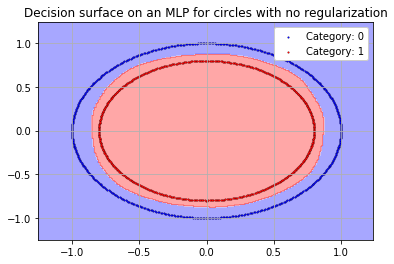

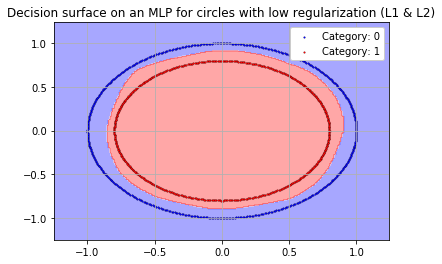

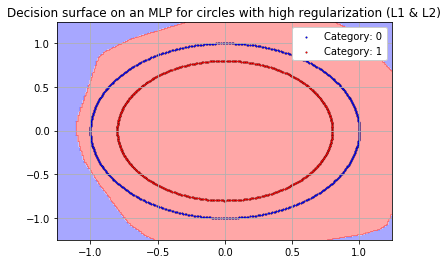

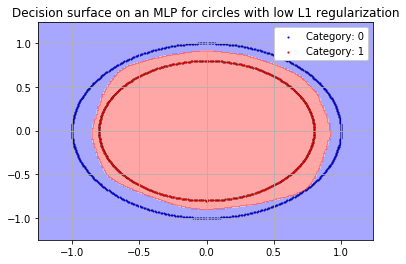

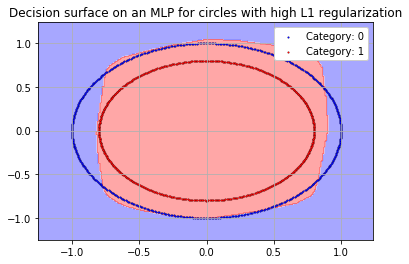

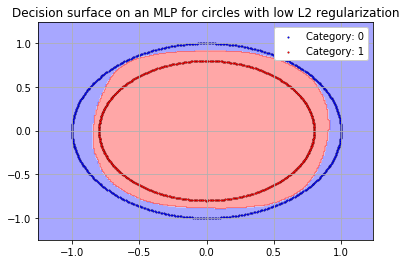

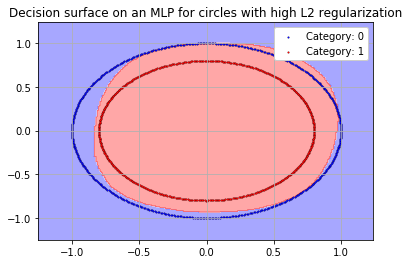

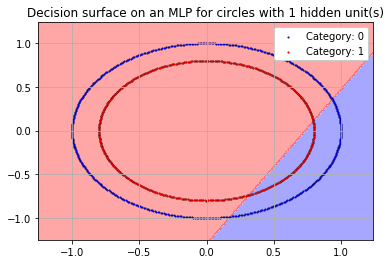

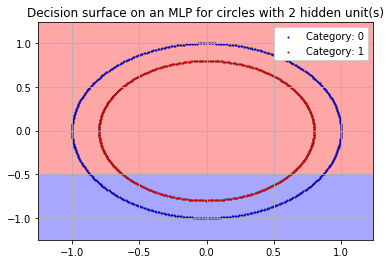

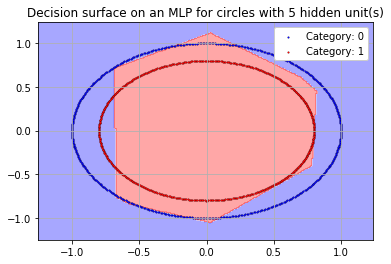

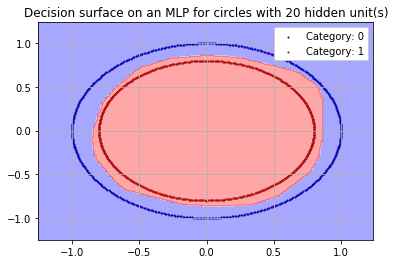

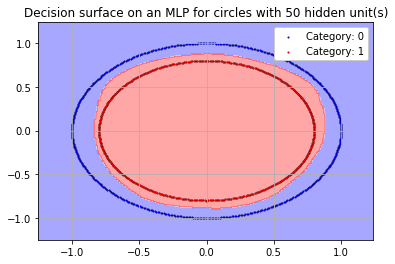

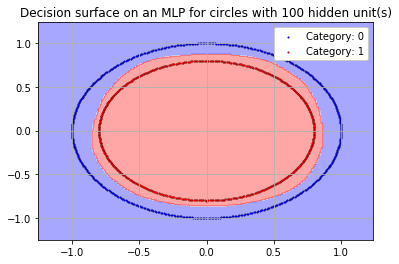

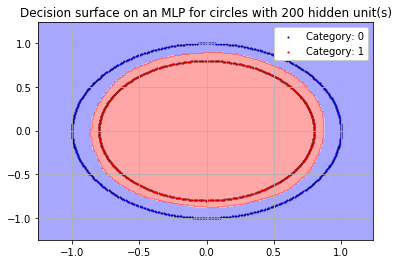

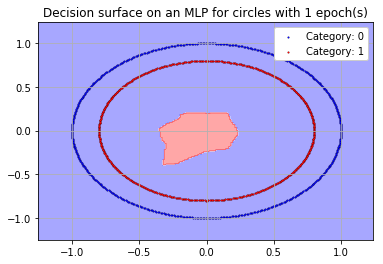

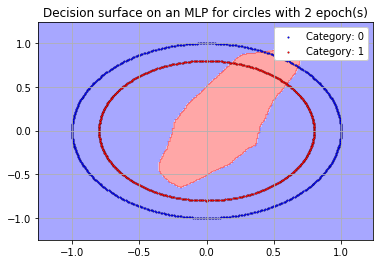

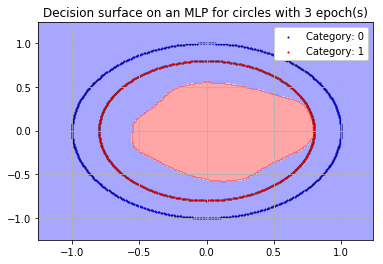

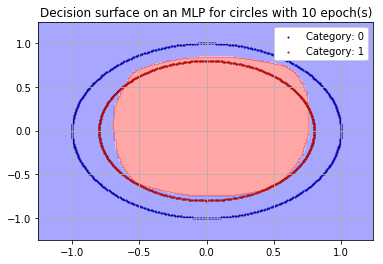

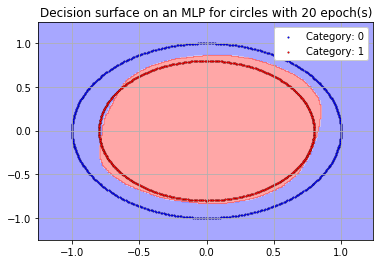

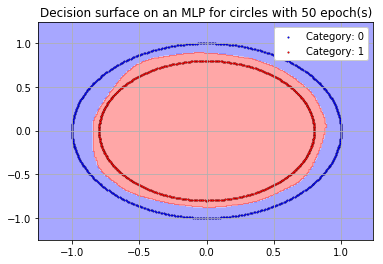

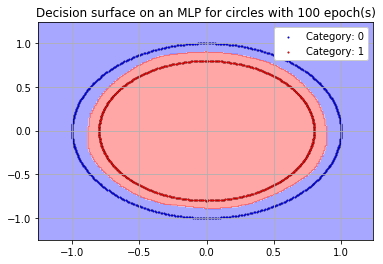

In [18]:
# constants
save_dir = os.path.join('results', 'experiment5')

# Load data
circle = np.loadtxt(os.path.join('data', 'circles.txt'))
x = circle[:, :-1].T
y = np.clip(circle[:, -1].T.reshape(1, -1), 0, 1).astype(int)

# Varying weight decay
lr = 0.001
lambdas = [([0.0, 0.0, 0.0, 0.0], 'Decision surface on an MLP for circles with no regularization'),
           ([0.003, 0.003, 0.003, 0.003], 'Decision surface on an MLP for circles with low regularization (L1 & L2)'),
           ([0.006, 0.006, 0.006, 0.006], 'Decision surface on an MLP for circles with high regularization (L1 & L2)'),
           ([0.005, 0.0, 0.005, 0.0], 'Decision surface on an MLP for circles with low L1 regularization'),
           ([0.0075, 0.0, 0.0075, 0.0], 'Decision surface on an MLP for circles with high L1 regularization'),
           ([0.0, 0.015, 0.0, 0.015], 'Decision surface on an MLP for circles with low L2 regularization'),
           ([0.0, 0.02, 0.0, 0.02], 'Decision surface on an MLP for circles with high L2 regularization')]
hidden = 200
epochs = 50
batch_size = 500
for i, (lambda_, title) in enumerate(lambdas):
    inputs = len(x)
    outputs = len(np.unique(y))
    mlp = MLP(inputs, hidden, outputs, lambda_)
    mlp.fit(x, y, batch_size, epochs, lr)
    name = os.path.join(save_dir, 'lambda', 'lambda_{}'.format(i))
    plot_decision_boundary(mlp, x, y, title, name)

# Varying number of hidden units
lr = 0.001
lambdas = [0.001, 0.0001, 0.001, 0.001]
hiddens = [1, 2, 5, 20, 50, 100, 200]
epochs = 50
batch_size = 500
for i, hidden in enumerate(hiddens):
    inputs = len(x)
    outputs = len(np.unique(y))
    mlp = MLP(inputs, hidden, outputs, lambdas)
    mlp.fit(x, y, batch_size, epochs, lr)
    # name = os.path.join(save_dir, 'hidden', 'hidden_{}'.format(i))
    title = 'Decision surface on an MLP for circles with {} hidden unit(s)'.format(hidden)
    plot_decision_boundary(mlp, x, y, title, name)

# Varying number of epochs
lr = 0.001
lambdas = [0.001, 0.0001, 0.001, 0.001]
hidden = 100
epochs = [1, 2, 3, 10, 20, 50, 100]
batch_size = 500
for i, epoch in enumerate(epochs):
    inputs = len(x)
    outputs = len(np.unique(y))
    mlp = MLP(inputs, hidden, outputs, lambdas)
    mlp.fit(x, y, batch_size, epoch, lr)
    # name = os.path.join(save_dir, 'epochs', 'epochs_{}'.format(i))
    title = 'Decision surface on an MLP for circles with {} epoch(s)'.format(epoch)
    plot_decision_boundary(mlp, x, y, title, name)


Notice how increasing regularization, running the MLP for a low number of epochs, and having few hidden units shrinks the size of the decision boundary. In that sense, all of these factors decrease the capacity of the MLP.

# Experiment 6: Matrix forms

The modifications made for the backward calculation are the most important:
```python
	def backward_pass(self, x, y):
		# Gradient of loss wrt output activation
		grad_oa = self.cost.backward(self.fprop['os'], y)
		self.bprop['grad_oa'] = grad_oa

		# Gradient of loss wrt bias 2
		# Add np.sum over axis 1 when batch
		grad_b2 = np.sum(grad_oa, axis=1, keepdims=True)
		self.bprop['grad_b2'] = grad_b2
		# Gradient of loss wrt weights 2
		# The penalization has to be added the same number of times as the number of examples!
		reps = grad_oa.shape[-1]
		grad_w2 = np.matmul(grad_oa, np.transpose(self.fprop['hs']))
		grad_w2_pen = reps*(self.lambdas[2]*np.sign(self.params['w2'] + self.lambdas[3]*2*(self.params['w2']))
```

1.  Gradient of w1 and w2 had to change to use the number of samples used. The penalization has to be done the same number of times os samples being calculated.
2. Sum over the columns of gradients of b. Since doing the bacward op in b gives us a matrix me have to sum over the columns to obtain the corresponding value.
3. We also included the cost to be in matrix form. This resulted in a hadamard product of the corrsponding labels and the obtained predictions (included in cost.py as the forward method of the LogCost class).

# Experiment 7: Matrix forms versus loops gradient checking

In [19]:
for n in [1, 10]:
    inputs = 2
    outputs = 1
    hidden = 2
    lambdas = [0.19, 0.45, 0.12, 0.3]
    x = np.random.rand(inputs, n)
    y = np.random.randint(0, outputs, (1, n))

    # Loop form
    mlp = MLP(inputs, hidden, outputs, lambdas, matrix=False)
    numerical_gradient_w2, check_w2 = gradient_check('w2', mlp, 10e-5, x, y)
    numerical_gradient_b2, check_b2 = gradient_check('b2', mlp, 10e-5, x, y)
    numerical_gradient_w1, check_w1 = gradient_check('w1', mlp, 10e-5, x, y)
    numerical_gradient_b1, check_b1 = gradient_check('b1', mlp, 10e-5, x, y)
    experiment_7_loop = {
        'numerical_gradient_w2': numerical_gradient_w2,
        'grad_w2': mlp.bprop['grad_w2'],
        'check_w2': check_w2,
        'numerical_gradient_b2': numerical_gradient_b2,
        'grad_b2': mlp.bprop['grad_b2'],
        'check_b2': check_b2,
        'numerical_gradient_w1': numerical_gradient_w1,
        'grad_w1': mlp.bprop['grad_w1'],
        'check_w1': check_w1,
        'numerical_gradient_b1': numerical_gradient_b1,
        'grad_b1': mlp.bprop['grad_b1'],
        'check_b1': check_b1}

    # Matrix form
    mlp = MLP(inputs, hidden, outputs, lambdas)
    numerical_gradient_w2, check_w2 = gradient_check('w2', mlp, 10e-5, x, y)
    numerical_gradient_b2, check_b2 = gradient_check('b2', mlp, 10e-5, x, y)
    numerical_gradient_w1, check_w1 = gradient_check('w1', mlp, 10e-5, x, y)
    numerical_gradient_b1, check_b1 = gradient_check('b1', mlp, 10e-5, x, y)
    experiment_7_matrix = {
        'numerical_gradient_w2': numerical_gradient_w2,
        'grad_w2': mlp.bprop['grad_w2'],
        'check_w2': check_w2,
        'numerical_gradient_b2': numerical_gradient_b2,
        'grad_b2': mlp.bprop['grad_b2'],
        'check_b2': check_b2,
        'numerical_gradient_w1': numerical_gradient_w1,
        'grad_w1': mlp.bprop['grad_w1'],
        'check_w1': check_w1,
        'numerical_gradient_b1': numerical_gradient_b1,
        'grad_b1': mlp.bprop['grad_b1'],
        'check_b1': check_b1}
    
    print('Loop gradients for k = {}\n'.format(n))
    for key in experiment_7_loop.keys():
        print(key.replace(',', ' ')+'\n')
        print(pd.DataFrame(experiment_7_loop[key]).to_string(index=False, header=0))
        print('\n')
        
    print('Matrix gradients for k = {}\n'.format(n))  
    for key in experiment_7_matrix.keys():
        print(key.replace(',', ' ')+'\n')
        print(pd.DataFrame(experiment_7_matrix[key]).to_string(index=False, header=0))
        print('\n')

Loop gradients for k = 1

numerical_gradient_w2

-0.232783 -0.249992


grad_w2

-0.232813 -0.250022


check_w2

0.999871  0.99988


numerical_gradient_b2

0.0


grad_b2

0.0


check_b2

1.0


numerical_gradient_w1

0.359043 -0.640924
-0.375439  0.292024


grad_w1

0.358998 -0.640969
-0.375484  0.291979


check_w1

1.000125  0.999930
0.999880  1.000154


numerical_gradient_b1

0.0
0.0


grad_b1

0.0
0.0


check_b1

1.0
1.0


Matrix gradients for k = 1

numerical_gradient_w2

-0.218777 -0.540222


grad_w2

-0.218807 -0.540252


check_w2

0.999863  0.999944


numerical_gradient_b2

0.0


grad_b2

0.0


check_b2

1.0


numerical_gradient_w1

-0.645170 -0.272237
-0.216281  0.582127


grad_w1

-0.645215 -0.272282
-0.216326  0.582082


check_w1

0.999930  0.999835
0.999792  1.000077


numerical_gradient_b1

0.0
0.0


grad_b1

0.0
0.0


check_b1

1.0
1.0


Loop gradients for k = 10

numerical_gradient_w2

1.347065 -3.071493


grad_w2

0.134676 -0.307179


check_w2

1.000223  0.999902


numeric

Checking the gradients again shows how the ratios are all close to 1. 

# Experiment 8: Fashion MNIST timing
To run this experiment you need to include below the path to the Fashion-MNIST repo `utils` directory. Additionally, the training and testing data must be under `data/fashion

In [20]:
import sys
import time
sys.path.append('../fashion-mnist/utils')
import mnist_reader

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')

# transpose to match dims to mlp expected format
X_train = X_train.T
y_train = np.expand_dims(y_train, axis=-1).T

d = 784
K = 100
dh = 10
m = 10
lambdas = [0.01, 0.01, 0.01, 0.01]
mlp_m = MLP(d, dh, m, lambdas, matrix=True)
mlp_l = MLP(d, dh, m, lambdas, matrix=False)

start_m = time.time()
mlp_m.fit(X_train, y_train, K, 1, 1e-5)
stop_m = time.time()

matrix_time = stop_m - start_m
print('Time elapsed for 1 epoch using matrix forms: {a:.3f} seconds'.format(a=matrix_time))

start_l = time.time()
mlp_l.fit(X_train, y_train, K, 1, 1e-5)
stop_l = time.time()
loop_time = stop_l - start_l
print('Time elapsed for 1 epoch using loop: {a:.3f} seconds'.format(a=loop_time))

ModuleNotFoundError: No module named 'mnist_reader'

As expected, the matrix form speeds up training significantly.

# Experiment 9: Code adapatation for error loss



The modifications made are to the fit method pf the MLP class, the code added to perform this is:
```
y_pred = self.predict(x_train)
            errors['train'].append(self.classification_error(y_pred, y_train))

if x_val is not None:
    self.forward_pass(x_val)
    self.calculate_cost(y_val)
    cost_val = self.fprop['cost']
    losses['val'].append(np.sum(cost_val) / x_val.shape[-1])
    y_pred_val = self.predict(x_val)
    errors['val'].append(self.classification_error(y_pred_val, y_val))
if x_test is not None:
    self.forward_pass(x_test)
    self.calculate_cost(y_test)
    cost_test = self.fprop['cost']
    losses['test'].append(np.sum(cost_test) / x_test.shape[-1])
    y_pred_test = self.predict(x_test)
    errors['test'].append(self.classification_error(y_pred_test, y_test))

if self.verbose:
    print('-' * 80)
    print('Epoch {}'.format(j))
    loss_message = 'train loss = {:.5f}'
    error_message = 'train error = {:.5f}'
    if x_val is not None and x_test is None:
        loss_message += ', val loss = {:.5f}'
        error_message += ', val error = {:.5f}'
        print(loss_message.
              format(losses['train'][-1], losses['val'][-1]))
        print(error_message.
              format(errors['train'][-1], errors['val'][-1]))
    elif x_test is not None and x_test is not None:
        loss_message += ', test loss = {:.5f}'
        error_message += ', test error = {:.5f}'
        print(loss_message.
              format(losses['train'][-1], losses['val'][-1], losses['test'][-1]))
        print(error_message.
              format(errors['train'][-1], errors['val'][-1], errors['test'][-1]))
    else:
        print(loss_message.format(losses['train'][-1]))
        print(error_message.format(errors['train'][-1]))

save_log('results/log.txt', losses, errors, self.n_hidden, eta, K)
return losses, errors
```

# Experiment 10: Error and loss functions on train/val/test 

We split the test in val/test using a 70/30 split

In [3]:
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')
X_test = X_test.T
y_test = np.expand_dims(y_test, axis=-1).T
# Test/val splitting is done on the test set using a 70/30 split
X_val = X_test[:, 0:3000]
y_val = y_test[:, 0:3000]

X_test = X_test[:, 3000:]
y_test = y_test[:, 3000:]

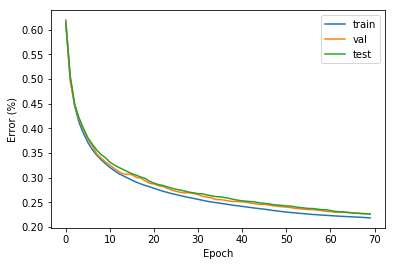

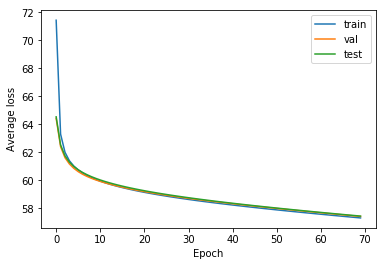

In [12]:
dh = 400
lambdas = [0.01, 0.01, 0, 0.01]
mlp_m = MLP(d, dh, m, lambdas, matrix=True, verbose=False)

losses, errors = mlp_m.fit(X_train, y_train, K, 70, 1e-8, X_val, y_val, X_test, y_test)

train_cost = np.expand_dims(np.asarray(losses['train']), axis=0)
train_error = np.expand_dims(np.asarray(errors['train']), axis=0)
val_cost = np.expand_dims(np.asarray(losses['val']), axis=0)
val_error = np.expand_dims(np.asarray(errors['val']), axis=0)
test_cost = np.expand_dims(np.asarray(losses['test']), axis=0)
test_error = np.expand_dims(np.asarray(errors['test']), axis=0)

costs = np.vstack((train_cost, val_cost, test_cost))
errors = np.vstack((train_error, val_error, test_error))

plot_functions(errors, ['train', 'val', 'test'], ['Epoch', 'Error (%)'])
plot_functions(costs, ['train', 'val', 'test'], ['Epoch', 'Average loss'])